**Домашнее задание**

Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.  
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")["Count"]

В первую очередь посмотрим с чем имеем дело.

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
Lags Used                      12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


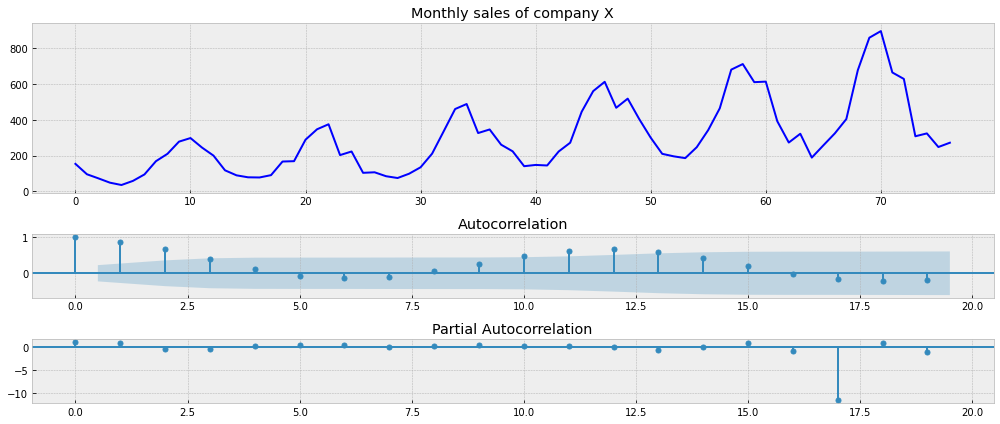

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 6), style='bmh', title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return


tsplot(sales_of_company_x, title="Monthly sales of company X")

Очевидно, что график нестационарный, имеется и тренд и сезонность. С трендом ARIMA должна справиться.

Методом грубой силы подберем параметры для формулы ARIMA:
где:
$$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$$  
p - порядок авторегрессии тренда;  
d - порядок изменения тренда (степень дифференцирования);  
q - тренд скользящей средней.

In [4]:
best_aic = np.inf 
best_order = None
best_mdl = None

for p in range(10):
    for d in range(10):
        for q in range(10):
            try:
                tmp_mdl = smt.ARIMA(sales_of_company_x, order=(p, d, q)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except:
                continue


print(f"Подобранные параметры: p = {best_order[0]}, d = {best_order[1]}, q = {best_order[2]}.")

/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Подобранные параметры: p = 3, d = 1, q = 2.


Все значения меньше 10, а, значит, дальше не имеет смысла перебирать.

Посмотрим на остатки.

Results of Dickey-Fuller Test:
Test Statistic                 -2.024893
p-value                         0.275766
Lags Used                      11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


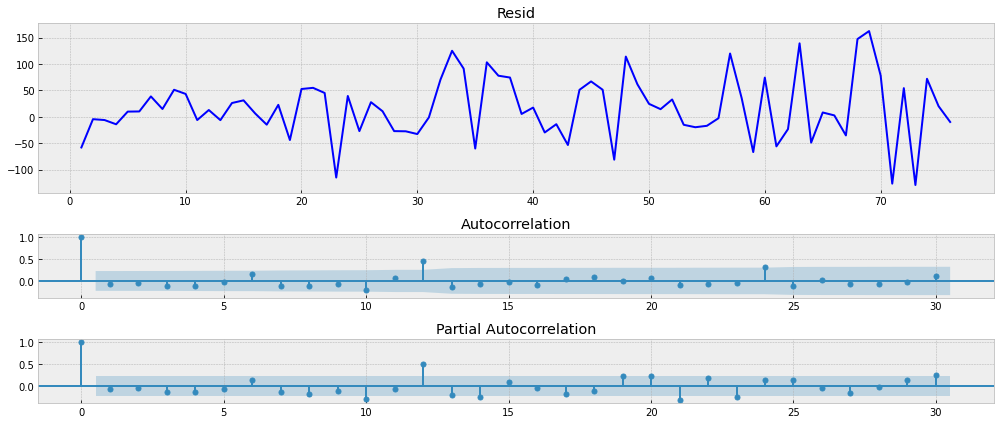

In [5]:
tsplot(best_mdl.resid, lags=30, title="Resid")

По графикам видно, что остатки представляют собой почти белый шум. На графике частичной автокорреляции прослеживается сезонность в 12 месяцев.

Попробуем то же самое с SARIMA, там параметры те же, плюс добавляются аналогичные сезонные ps, ds, qs, а также длина сезона.

In [6]:
best_aic = np.inf 
best_order = None
best_mdl = None
slen = 12

for p in range(4):
    for d in range(4):
        for q in range(4):
            for ps in range(4):
                for ds in range(4):
                    for qs in range(4):
                        try:
                            tmp_mdl = smt.SARIMAX(sales_of_company_x, order=(p, d, q),
                                seasonal_order=(ps, ds, qs, slen)).fit(trend='nc')
                            tmp_aic = tmp_mdl.aic
                            if tmp_aic < best_aic:
                                best_aic = tmp_aic
                                best_order = (p, d, q, ps, ds, qs)
                                best_mdl = tmp_mdl
                        except:
                            continue

print(f"""Подобранные параметры: p = {best_order[0]}, d = {best_order[1]}, q = {best_order[2]},\n
      ps = {best_order[3]}, ds = {best_order[4]}, qs = {best_order[5]}""")

/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/media/ilia/Vol3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Подобранные параметры: p = 1, d = 3, q = 2,

      ps = 0, ds = 3, qs = 0


Посмотрим на остатки.

Results of Dickey-Fuller Test:
Test Statistic                 -2.675557
p-value                         0.078364
Lags Used                      12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


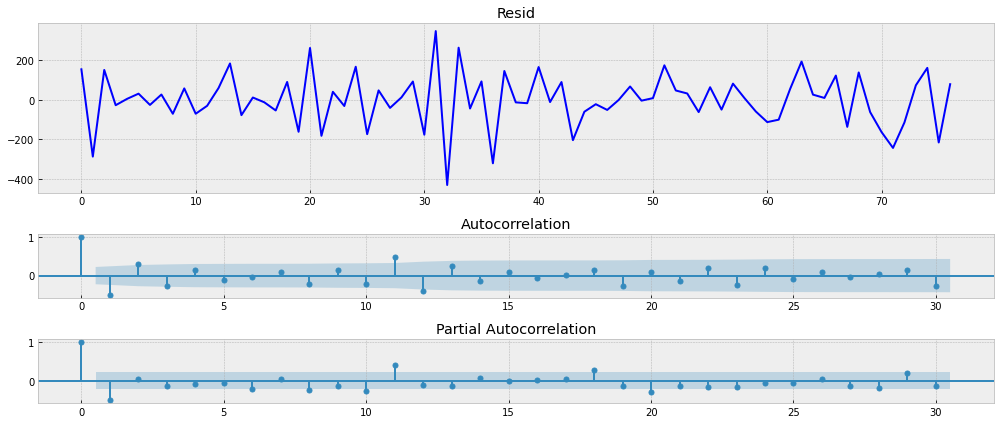

In [7]:
tsplot(best_mdl.resid, lags=30, title="Resid")

Стало лучше, но все равно хуже, чем хотелось бы, т.к. p-value > 0.05. Возможно, стоило перебрать больше значений параметров.

Попробуем спрогнозировать то же самое, но обычной линейной регрессией.

Сгенерируем признаковое пространство. Целевым будет наш временной ряд, а признаками - его смещение на номер лага.

In [8]:
def feature_space_generate(data, lag_start, lag_end):
    data = pd.DataFrame(data.copy())
    
    # добавляем лаги исходного ряда в качестве признаков смещением
    # т.е. каждый признак - это оригинальная последовательность, смещенная на номер лага
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data["Count"].shift(i)
    
    # поскольку в резльтате смещения получились NaN значения, то строки с этими признакими нужно отбросить
    data = data.dropna()
    data = data.reset_index(drop=True)
    return data


space = feature_space_generate(sales_of_company_x, lag_start=5, lag_end=20)
space.head(5)

,Count,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,169,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0,154.0
1,289,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0
2,347,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0
3,375,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0
4,203,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0


Разделим выборку на train и test.

In [9]:
def tt_split(data, target_feature, test_size):
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target_feature], axis=1)
    y_train = data.loc[:test_index][target_feature]
    X_test = data.loc[test_index:].drop([target_feature], axis=1)
    y_test = data.loc[test_index:][target_feature]
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = tt_split(space, "Count", 0.3)

Строим модель линеной регресии и график предсказания.

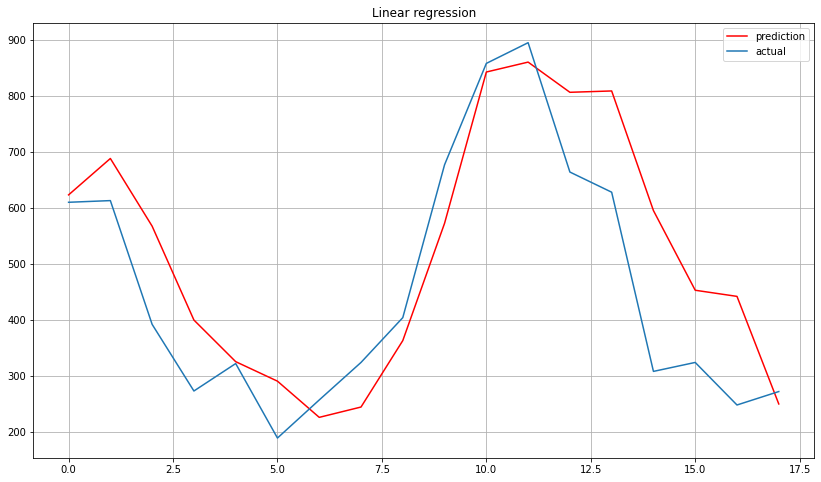

Оценка качества модели (R^2): 0.6681888224408006.


In [10]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid()
plt.show()

print(f"Оценка качества модели (R^2): {model.score(X_test, y_test)}.")

Как видим, модель линеной регрессии смогла сделать прогноз. Правда, качество далеко не лучшее. Однако, стоит принять во внимание тот факт, что датасет для обучения у нас очень небольшой.